# **Дополнительное домашнее задание. Логистическая регрессия и решающие деревья**

Суммарно 10 баллов за всю работу. По 5 баллов в каждой части.

Требуется выполнить следующие задания.

In [115]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import random

from __future__ import annotations

In [116]:
import warnings 
warnings.filterwarnings("ignore")

## **Часть 1. Логистическая регрессия (5 баллов)**

**Задание 1 (3 балла)**. Реализуйте логистическую регрессию, обучаемую с помощью двух видов градиенткого спуска:
- полный (по всем данным) градиентный спуск;

- стохастический градиентный спуск;

Во всех пунктах необходимо соблюдать два условия:
- Циклы можно использовать только для итераций градиентного спуска.
- В качестве критерия останова необходимо использовать (одновременно):

    - проверку на евклидову норму разности весов на двух соседних итерациях (например, меньше некоторого малого числа порядка 1e-6), задаваемого параметром `tolerance`;
    - достижение максимального числа итераций (например, 10000), задаваемого параметром `max_iter`.

Чтобы проследить, что оптимизационный процесс действительно сходится, добавьте атрибут класса `loss_history`. В нем после вызова метода `fit` должны содержаться значения функции потерь для всех итераций градиентного спуска, начиная с нулевой.

Инициализировать веса можно случайным образом или нулевым вектором.

In [117]:
from sklearn.base import BaseEstimator

from sklearn.metrics import precision_recall_curve, roc_auc_score, roc_curve, auc, average_precision_score

from sklearn.model_selection import KFold

In [ ]:
class MyLogisticRegression(BaseEstimator):
    def __init__(self, gd_type: str = 'stochastic', tolerance: float = 1e-6,
                 max_iter: int = 1000, eta: float = 1e-2,
                 w0: np.array = None) -> None:
        """
        Аргументы:
          gd_type: вид градиентного спуска ('full' или 'stochastic').

          tolerance: порог для остановки градиетного спуска.

          max_iter: максимальное количество шагов в градиентном спуске.

          eta: скорость обучения (learning rate).

          w0: массив размерности d (d — количество весов в оптимизации).
              Начальные веса.
        """
        self.gd_type = gd_type
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.eta = eta
        self.w0 = w0
        self.w = None
        self.loss_history = None


    def fit(self, X: np.array, y: np.array):
        """Обучаем модель на training данных. Сохраняйте значении функции потерь после каждой итерации.

        Аргументы:
          X: данные на обучение.

          y: целевая переменная.

        Возвращает:
          self: обученный регрессор.
        """
        self.loss_history = []

        # Инициализация весов
        if self.w0 is not None:
            self.w = self.w0.copy()
        else:
            self.w = np.zeros(X.shape[1])

        for _ in range(self.max_iter):
            w_prev = self.w.copy()  # Сохраняем предыдущие веса для проверки сходимости
        
            # Выбор стратегии градиентного спуска
            if self.gd_type == "full":
                gradient = self.calc_gradient(X, y)  # Градиент по всей выборке
                self.w -= self.eta * gradient
            elif self.gd_type == "stochastic":
              random_idx = np.random.randint(0, len(X))
              x_i = X[random_idx : random_idx + 1]
              y_i = y[random_idx : random_idx + 1]
              gradient = self.calc_gradient(x_i, y_i)
              self.w -= self.eta * gradient
            else:
                raise Exception('Нет такого типа gd')
            
            current_loss = self.calc_loss(X, y)
            self.loss_history.append(current_loss)

            # Проверка сходимости (норма разницы весов)
            weight_diff_norm = np.linalg.norm(self.w - w_prev)
            if weight_diff_norm < self.tolerance:
                break
        return self


    def predict_proba(self, X: np.array) -> np.array:
        """Вычислите вероятности положительного и отрицательного классов для каждого наблюдения.

        Аргументы:
          X: массив размером (n, d).
             Данные.

        Возвращает:
             Массив размером (n, 2).
             Предсказанные вероятности.
        """
        if self.w is None:
            raise Exception('Сначала запустите fit')

        return self.sigmoid(X @ self.w)


    def predict(self, X: np.array) -> np.array:
        """Предсказание метки класса для каждого наблюдения.

        Аргументы:
          X: массив размером (n, d).
             Данные.

        Возвращает:
             Массив размером (n,).
             Предсказанные метки классов.
        """
        if self.w is None:
            raise Exception('Сначала запустите fit')
        
        probs = self.sigmoid(X @ self.w) # Вычисляем вероятности класса 1
        preds = (probs > 0.5).astype(int)
        return preds


    def calc_gradient(self, X: np.array, y: np.array) -> np.array:
        """Вычислите градиент функции потерь после каждой итерации.

        Аргументы:
          X: массив размером (n, d), n может быть равно 1, если выбран 'stochastic'.
          y: массив размером (n,).

        Возвращает:
          Массив размером (d,).
          Градиент функции потерь после текущей итерации.
        """
        z = X @ self.w
        y_pred = self.sigmoid(z)
        gradient = X.T @ (y_pred - y) / len(X)
        return gradient


    def calc_loss(self, X: np.array, y: np.array) -> float:
        """Вычислите значение функции потерь после каждой итерации.

        Аргументы:
          X: массив размером (n, d).
          y: массив размером (n,).

        Возвращает:
          Значение функции потерь после текущей итерации.
        """
        eps = 1e-10 # добавляем минимальное значение к вычисляемым логорифмам
        z = X @ self.w
        y_pred = self.sigmoid(z)
        loss = -np.mean(y * np.log(y_pred + eps) + (1 - y) * np.log(1 - y_pred + eps))
        return loss
    

    def sigmoid(self, z: np.array) -> np.array:
        """Вычисление сигмоиды"""
        return 1 / (1 + np.exp(-z))

Далее предполагается, что вы используете собственную реализацию логистической регрессии.
Если с написанием класса возникли проблемы, используйте реализацию sklearn, чтобы не терять баллы за остальные задания.

Сгенерируем искусственные данные.

In [119]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5,
    random_state=999)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=999)

**Задание 2 (1 балл).** Обучите логистическую регрессию на искусственных данных. Нарисуйте изменение лосса во время обучения.

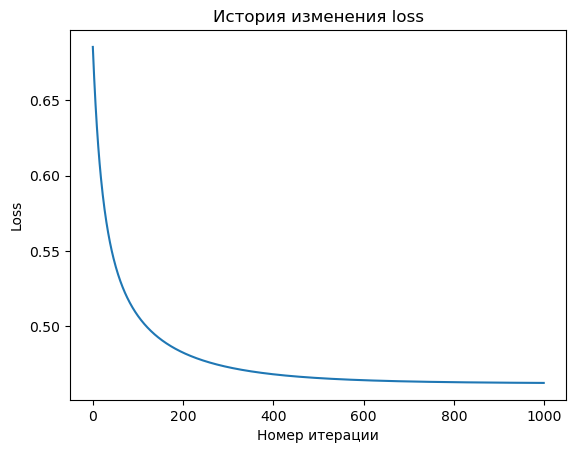

In [120]:
my_reg = MyLogisticRegression(gd_type='full')
my_reg.fit(X_train, y_train)

plt.plot(my_reg.loss_history)
plt.xlabel('Номер итерации')
plt.ylabel('Loss')
plt.title('История изменения loss')
plt.show()

На тестовой части посчитайте ROC-AUC, PR-AUC. Постройте ROC- и PR-кривые.

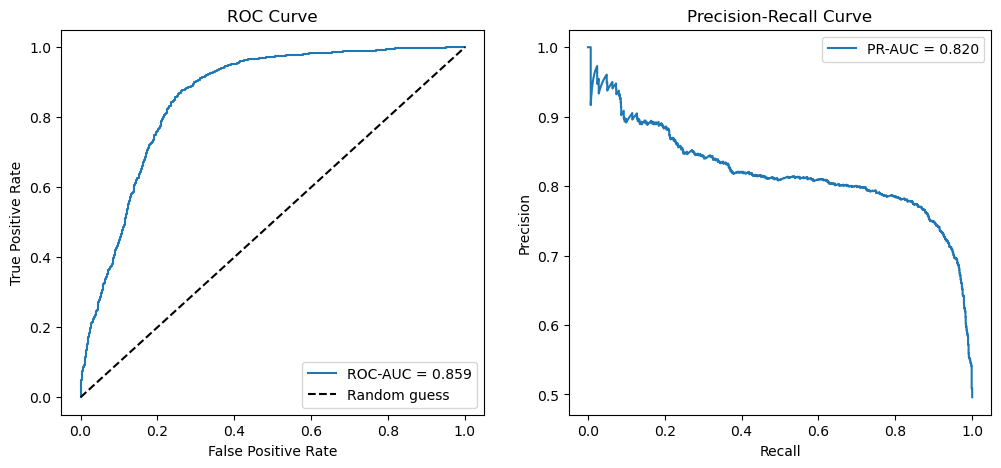

In [121]:
y_proba = my_reg.predict_proba(X_test)

# Расчет метрик ROC-AUC
roc_auc = roc_auc_score(y_test, y_proba)
fpr, tpr, _ = roc_curve(y_test, y_proba)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f'ROC-AUC = {roc_auc:.3f}')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

# PR-AUC
pr_auc = average_precision_score(y_test, y_proba)
precision, recall, _ = precision_recall_curve(y_test, y_proba)

plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f'PR-AUC = {pr_auc:.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

**Задание 3 (1 балл).** Оцените ошибку ROC-AUC и PR-AUC вашей модели при помощи K-fold кросс-валидации.  

In [122]:
kf = KFold(shuffle=True)

roc_auc_scores = []
pr_auc_scores = []

for train_idx, val_idx in kf.split(X, y):
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]
    
    model = MyLogisticRegression(gd_type='full')
    model.fit(X_train, y_train)
    
    y_pred = model.predict_proba(X_val)
    
    # Расчёт метрик
    roc_auc = roc_auc_score(y_val, y_pred)
    pr_auc = average_precision_score(y_val, y_pred)
    
    roc_auc_scores.append(roc_auc)
    pr_auc_scores.append(pr_auc)

# Усреднённые результаты
print(f"ROC-AUC: {np.mean(roc_auc_scores):.4f}")
print(f"PR-AUC: {np.mean(pr_auc_scores):.4f}")

ROC-AUC: 0.8607
PR-AUC: 0.8321


## **Часть 2. Решающие деревья (5 баллов)**

Здесь требуется реализовать разбиение элементов выборки в вершине дерева.

$R_m$ — множество объектов в разбиваемой вершине, $j$ — номер признака, по которому происходит разбиение, $t$ — порог разбиения.

Критерий ошибки:

$$
Q(R_m, j, t) = \frac{|R_\ell|}{|R_m|}H(R_\ell) + \frac{|R_r|}{|R_m|}H(R_r) \to \min_{j, t}
$$

$R_\ell$ — множество объектов в левом поддереве, $R_r$ — множество объектов в правом поддереве.

$H(R)$ — критерий информативности, с помощью которого можно оценить качество распределения целевой переменной среди объектов множества $R$.

In [123]:
from typing import Iterable, List, Tuple

Так как Boston Dataset с недавних пор отсутствует в sklearn, то ниже реализован способ загрузки данного датасета из другого источника.

In [ ]:
# `load_boston` has been removed from scikit-learn since version 1.2.

#from sklearn.datasets import load_boston
#boston = load_boston()

In [ ]:
# !wget -i https://github.com/scikit-learn/scikit-learn/blob/main/sklearn/datasets/data/boston_house_prices.csv
#data_git = pd.read_csv('boston_house_prices.csv', sep="\s+")

**Data Set Characteristics:**  

    :Number of Instances: 506

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
        - B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
        - LSTAT    % lower status of the population
        - MEDV     Median value of owner-occupied homes in $1000's

    :Missing Attribute Values: None

    :Creator: Harrison, D. and Rubinfeld, D.L.

This is a copy of UCI ML housing dataset.
https://archive.ics.uci.edu/ml/machine-learning-databases/housing/

This dataset was taken from the StatLib library which is maintained at Carnegie Mellon University.

The Boston house-price data of Harrison, D. and Rubinfeld, D.L. 'Hedonic
prices and the demand for clean air', J. Environ. Economics & Management,
vol.5, 81-102, 1978.   Used in Belsley, Kuh & Welsch, 'Regression diagnostics
...', Wiley, 1980.   N.B. Various transformations are used in the table on
pages 244-261 of the latter.

The Boston house-price data has been used in many machine learning papers that address regression
problems.   
     
.. topic:: References

   - Belsley, Kuh & Welsch, 'Regression diagnostics: Identifying Influential Data and Sources of Collinearity', Wiley, 1980. 244-261.
   - Quinlan,R. (1993). Combining Instance-Based and Model-Based Learning. In Proceedings on the Tenth International Conference of Machine Learning, 236-243, University of Massachusetts, Amherst. Morgan Kaufmann.



In [124]:
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

In [125]:
feature_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']

X = pd.DataFrame(data, columns=feature_names, index=range(len(data)))
y = pd.DataFrame(target, columns=['MEDV'], index=range(len(target)))

X['target'] = y

In [126]:
X_train, X_test = train_test_split(X, test_size=0.25, random_state=999)

**Задание 1 (1 балл)**. Реализуйте подсчет критерия ошибки. Для этого реализуйте функции для подсчета значения критерия информативности, а также для разбиения вершины.

In [127]:
def H(R: np.array) -> float:
    """
    Вычислить критерий информативности (impurity criterion) для фиксированного набора объектов R.
    Предполагается, что последний столбец содержит целевую переменную.
    """
    if len(R) == 0:
        return 0.0
    
    return np.var(R.iloc[:, -1])


def split_node(R_m: np.array, feature: str, t: float) -> Iterable[np.array]:
    """
    Разделить фиксированный набор объектов R_m с заданным признаком (номером признака) и пороговым значением t.
    """
    left_mask = R_m[feature] <= t
    return R_m[left_mask], R_m[~left_mask]


def q_error(R_m: np.array, feature: str, t: float) -> float:
    """
    Вычислить критерий ошибки для заданных параметров разделения.
    """
    left_R_m, right_R_m = split_node(R_m, feature, t)
    return len(left_R_m) / len(R_m) * H(left_R_m) + len(right_R_m) / len(R_m) * H(right_R_m)


**Задание 2 (1 балл)**. Переберите все возможные разбиения обучающей выборки по одному из признаков и постройте график критерия ошибки в зависимости от значения порога.

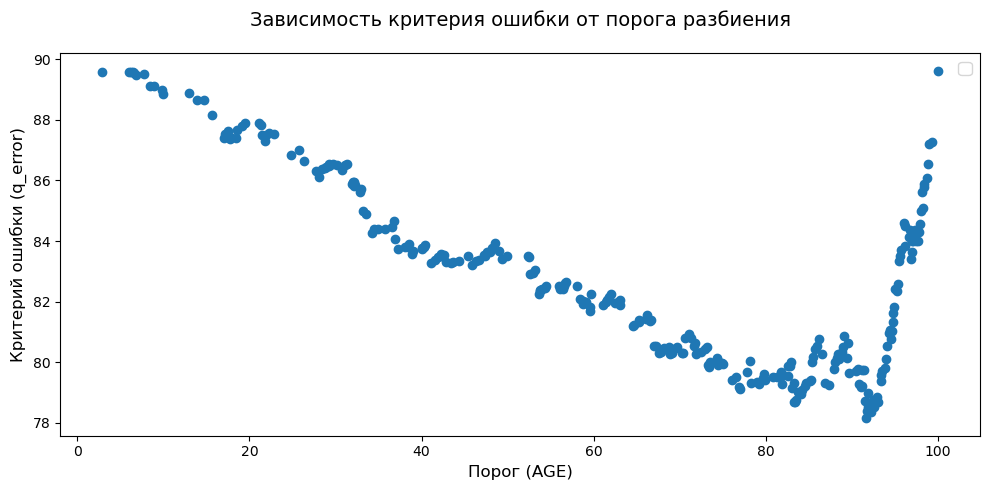

In [128]:
feature_name = "AGE"
thresholds = sorted(X_train[feature_name].unique())

errors = [q_error(X_train, feature_name, threshold) for threshold in thresholds]

plt.figure(figsize=(10, 5))
plt.scatter(x=thresholds, y=errors)
# Подписываем оси и добавляем заголовок
plt.xlabel("Порог (AGE)", fontsize=12)
plt.ylabel("Критерий ошибки (q_error)", fontsize=12)
plt.title("Зависимость критерия ошибки от порога разбиения", fontsize=14, pad=20)


# Добавляем легенду и улучшаем читаемость
plt.legend(fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()

plt.show()

**Задание 3  (1 балл)**. Напишите функцию, находящую оптимальное разбиение данной вершины по данному признаку.

In [129]:
def get_optimal_split(R_m: np.array, feature: str) -> Tuple[float, List[float]]:
    thresholds = sorted(R_m[feature_name].unique())
    errors = [q_error(R_m, feature, threshold) for threshold in thresholds]
    min_error = np.argmin(errors)
    return thresholds[min_error], errors[min_error]

**Задание 4  (1 балл)**. Для первого разбиения найдите признак, показывающий наилучшее качество. Каков порог разбиения и значение качества? Постройте график критерия ошибки для данного признака в зависимости от значения порога.

Признак: LSTAT; Порог: 9.9; Ошибка: 50.37703794258447


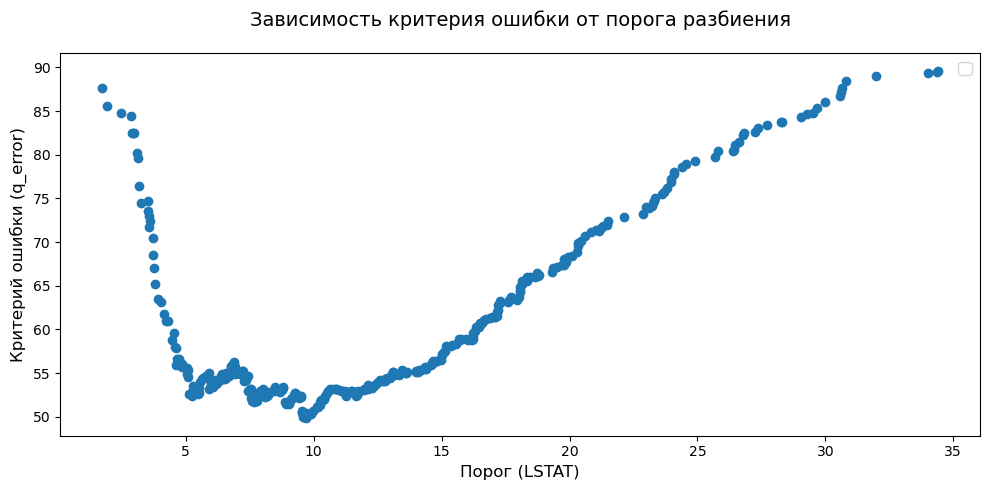

In [130]:
best_feature = feature_names[0]
best_thr, best_err = get_optimal_split(X_train, feature_names[0])

for feature in feature_names[1:]:
    thr, err = get_optimal_split(X_train, feature)
    if err <= best_err:
            best_thr = thr
            best_err = err
            best_feature = feature

print(f'Признак: {best_feature}; Порог: {best_thr}; Ошибка: {best_err}')

thresholds = sorted(X_train[best_feature].unique())

errors = [q_error(X_train, best_feature, threshold) for threshold in thresholds]

plt.figure(figsize=(10, 5))
plt.scatter(x=thresholds, y=errors)
# Подписываем оси и добавляем заголовок
plt.xlabel(f"Порог ({best_feature})", fontsize=12)
plt.ylabel("Критерий ошибки (q_error)", fontsize=12)
plt.title("Зависимость критерия ошибки от порога разбиения", fontsize=14, pad=20)


# Добавляем легенду и улучшаем читаемость
plt.legend(fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()

plt.show()

 **Задание 5 (1 балл)**. Изобразите разбиение визуально. Для этого постройте диаграмму рассеяния целевой переменной в зависимости от значения входного признака. Далее изобразите вертикальную линию, соответствующую порогу разбиения.

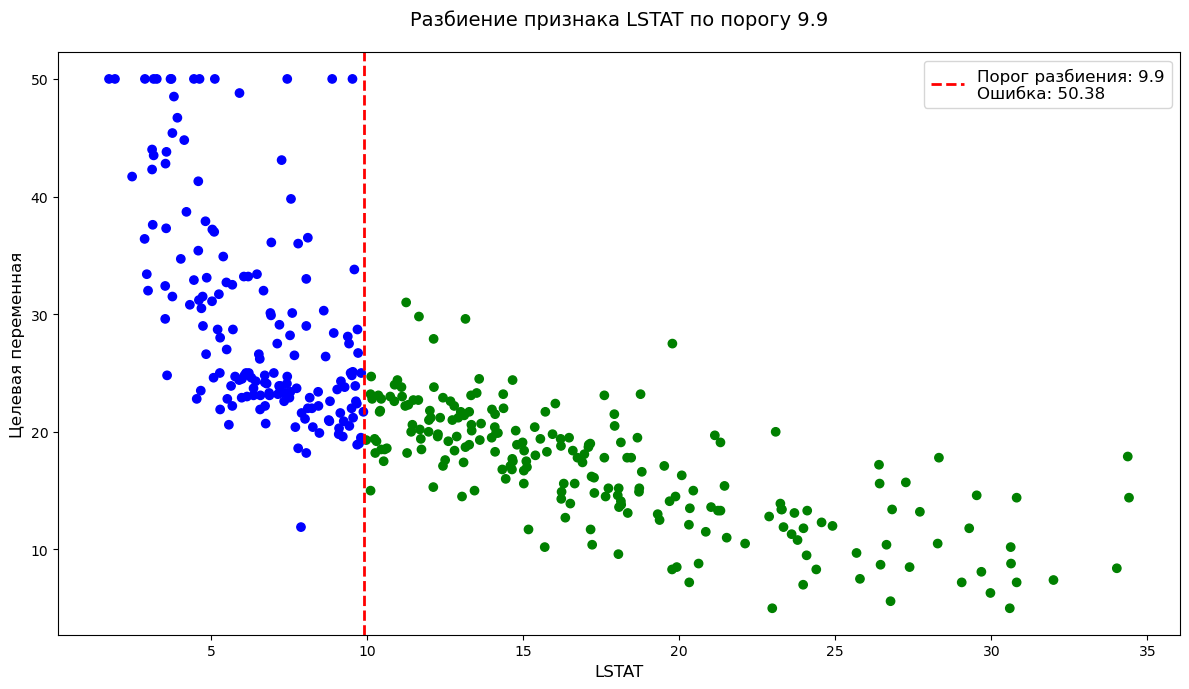

In [131]:
plt.figure(figsize=(12, 7))

scatter = plt.scatter(
    x=X_train[best_feature], 
    y=X_train['target'],
    c=np.where(X_train[best_feature] <= 9.9, 'blue', 'green'),
)
plt.axvline(x=best_thr, color='red', linestyle='--', linewidth=2, label=f'Порог разбиения: {best_thr}\nОшибка: {round(best_err, 2)}')
plt.title(f'Разбиение признака LSTAT по порогу {best_thr}', pad=20, fontsize=14)
plt.xlabel(best_feature, fontsize=12)
plt.ylabel('Целевая переменная', fontsize=12)
plt.legend(fontsize=12, loc='upper right')
plt.tight_layout()
plt.show()